Ron Levi, 213262140

Mohammed Wattad, 211413810


# Community In The Dark 🦇

Welcome to the **Community In The Dark** notebook! This project simulates a community of agents that must strategically adapt their features to "game" a hidden decision-making system (classifier). The simulation explores the trade-offs between gathering information (exploration) and acting on that knowledge (exploitation), while accounting for the cost of modifications.


## 1. Project Motivation and High-Level Overview

### Motivation
In many real-world systems—such as loan approvals, job applications, or online reputation systems—agents or individuals need to modify their behavior or attributes to receive favorable outcomes. However, these modifications come with costs. This project investigates:
- **How agents collectively learn** the hidden rules of a classifier through strategic exploration.
- **How agents then adapt** their features during exploitation if the cost of modification is justified by the potential gain.

### High-Level Overview
- **Hidden Classifier:**  
  A linear classifier with randomly generated weights and bias that assigns a label of **+1 (accepted)** or **–1 (rejected)** based on an agent's features.
  
- **Agents:**  
  Each agent is characterized by:
  - A **feature vector** (and a backup copy in `initial_features` for baseline comparison).
  - A **true label** (determined by the hidden classifier).
  - Flags to track if the agent has **explored** (queried the classifier) or **modified** its features.
  
- **Cost Functions & Reward:**  
  - **Cost Functions:**  
    Three cost functions (L1, L2, and L∞) measure the "expense" of modifying an agent’s features.
  - **Reward Function:**  
    A simple reward is given: **+1** if an agent is accepted and **–1** if rejected.

- **Phases of the Simulation:**
  1. **Exploration Phase:**  
     A percentage of agents query the hidden classifier. Their features and true labels are recorded to train an alternative classifier (a linear SVM) that approximates the hidden classifier.
     
  2. **Exploitation Phase:**  
     The remaining agents—or those initially rejected—use the trained SVM as guidance. They compute the minimal modification required (scaled by a safety margin) to cross the decision boundary. If the modification cost is below a gain threshold, the agent adopts the change.

---

### Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import pandas as pd
import plotly.graph_objects as go
from sklearn.cluster import KMeans
from collections import defaultdict

In [3]:
pip install plotly

### The initial cost functions

In [4]:
def cost_l1(x_old, x_new):
    return np.sum(np.abs(x_new - x_old))

def cost_l2(x_old, x_new):
    return np.linalg.norm(x_new - x_old)

def cost_linf(x_old, x_new):
    return np.max(np.abs(x_new - x_old))


### The initial reward function

In [5]:
def reward_function(label):
    return 1 if label == 1 else -1

## 2. Detailed Explanation of Core Components

### 2.1 The Agent Class

**Purpose:**  
Models individual community members.

**Key Fields:**
- `features`: The current feature vector.
- `initial_features`: A copy of the original features for baseline comparison and visualization.
- `true_label`: The label assigned by the hidden classifier.
- `modified`: Boolean flag indicating if the agent has modified its features.
- `explored`: Boolean flag indicating if the agent has participated in the exploration phase.

**Important Function:**
- `modify_features(modification, cost_func)`:  
  - **Input:** A modification vector and a cost function (L1, L2, or L∞).  
  - **Action:** Applies the modification to the agent’s features, computes the cost, updates the state (marks the agent as modified), and returns the incurred cost.

---

In [6]:
class Agent:
    def __init__(self, features, true_label=None):
        self.features = features
        self.initial_features = features.copy()  # store original position for baseline measurement & visualization
        self.true_label = true_label             # assigned by the true classifier
        self.modified = False                    # whether agent has modified its features
        self.explored = False                    # whether the agent participated in exploration

    def modify_features(self, modification, cost_func):
        new_features = self.features + modification
        c = cost_func(self.features, new_features)
        self.features = new_features
        self.modified = True
        return c

### 2.2 The Simulation Environment (`SimulationEnv` Class)

This class orchestrates the simulation from generating agents through exploration and exploitation to evaluation and visualization.

#### Key Fields:
- **Configuration:**
  - `hidden_dim`: Dimensionality of the feature space (e.g., 2 for visualization).
  - `num_agents`: Total number of agents.
  - `cost_functions`: A dictionary mapping `'l1'`, `'l2'`, and `'linf'` to their respective functions.
  - `cost_func`: The chosen cost function based on the provided configuration.

- **Hidden Classifier:**
  - `classifier_weights`: Randomly initialized weight vector.
  - `classifier_bias`: Randomly initialized bias term.
  
- **Proposed Classifier (SVM):**
  - `proposed_svm`: A linear SVM trained on exploration data to approximate the hidden classifier.

- **Exploration Data:**
  - `exploration_data_X`: List to store feature vectors collected during exploration.
  - `exploration_data_y`: List to store corresponding true labels.

- **Agents and Metrics:**
  - `agents`: List of `Agent` objects.
  - `last_utilities`: List storing the utility values computed during the exploitation phase.
  - `costs`: List storing modification costs incurred by agents.

#### Important Functions:
- **`generate_agents()`**:  
  Creates agents with random feature vectors and assigns true labels based on the hidden classifier. It ensures that at least one agent is positive and one negative.

- **`classify_agent(agent)`**:  
  Computes the classifier's score for an agent (using a dot product with `classifier_weights` plus `classifier_bias`) and returns the label.

- **`proposed_predict(features)`**:  
  Uses the trained SVM to predict a label for a given feature vector. (The SVM must be trained beforehand.)

- **`train_proposed_classifier()`**:  
  Trains the SVM using the exploration data (only if there are enough samples and at least two classes).

- **`simulation_step()`**:  
  Recomputes true labels for all agents—useful when agents modify their features.


### 2.3 Simulation Phases

#### Exploration Phase (`run_exploration_phase()`)
- **Objective:**  
  Gather training data by having a subset of agents query the hidden classifier.
- **Key Parameters:**
  - `exploration_budget_percentage`: Percentage of agents to select.
  - `strategy`: The method for selecting agents. Options include:
    - **Random:** Simple random sampling.
    - **Max Spread:** Selects agents farthest from the centroid.
    - **Clustering:** Uses K-Means to pick agents from diverse clusters.
- **Outcome:**  
  Agents selected in this phase are marked as `explored`, and their data is used to train the SVM.

#### Exploitation Phase (`run_exploitation_phase()`)
- **Objective:**  
  Allow agents (particularly those initially rejected) to modify their features based on the SVM's guidance.
- **Key Parameters:**
  - `safety_margin`: A scaling factor applied to the minimal modification needed to cross the decision boundary.
  - `retrain_every`: Optional parameter indicating the frequency of SVM retraining during exploitation.
- **Process:**
  - For each unexplored or rejected agent, compute the SVM decision function.
  - Calculate the minimal modification needed to flip the classification.
  - Scale this modification by the `safety_margin`.
  - If the cost (computed using the selected cost function) is below a set **gain threshold** (e.g., 2), the agent modifies its features.
  - Optionally, retrain the SVM periodically to incorporate new data from modified agents.

## 3. Mathematical Definitions

### Total Cost

$$
C_{\mathrm{total}} = \sum_{i=1}^{N} c(a_i)
$$

**Where**:
- \(N\) is the total number of agents.
- \(c(a_i)\) is the cost incurred by agent \(a_i\) when modifying its features.

---

### Total Utility

$$
U_{\mathrm{total}}
=
\sum_{i=1}^{N}
\Bigl(
    r(a_i)
    -
    c(a_i)
    \cdot
    \mathbf{1}\Bigl(\hat{r}(a_i) - c(a_i) > \mathrm{gain\_threshold}\Bigr)
\Bigr)
$$

**Where**:
- \(r(a_i)\) is the reward for agent \(a_i\) (either \(+1\) or \(-1\)).
- \(c(a_i)\) is the cost of modification for agent \(a_i\).
- \(\hat{r}(a_i)\) is the perceived reward of agent \(a_i\) (according to the classifier).
- \(\mathrm{gain\_threshold}\) is the minimum threshold for an agent to decide that modifying its features is worthwhile.
- \(\mathbf{1}(\cdot)\) is the indicator function that returns \(1\) if the condition is true, and \(0\) otherwise


## 4. Visualization Functions

Visualization is key to understanding the dynamics of the simulation. Important visualization functions include:

- **`plot_base_version()`**:  
  Displays the initial distribution of agents (based on `initial_features`), along with the true decision boundary.
  
- **`plot_optimal_modification_scenario(gain_threshold)`**:  
  Illustrates the optimal scenario where agents would make the exact minimal modification to cross the boundary, highlighting both the cost and the expected change.
  
- **`plot_environment()`**:  
  Shows the final state after the exploitation phase, including:
  - Agents that remain unmodified.
  - Agents that have modified their features (with arrows indicating direction and magnitude).
  - Decision boundaries for both the hidden classifier and the trained SVM.


In [34]:
# ----------------------------
# Simulation Environment Definition
# ----------------------------
class SimulationEnv:
    def __init__(self, hidden_dim=10, num_agents=100, cost_function='l1'):
        self.hidden_dim = hidden_dim
        self.num_agents = num_agents

        # Map cost function string to function.
        self.cost_functions = {'l1': cost_l1, 'l2': cost_l2, 'linf': cost_linf}
        if cost_function not in self.cost_functions:
            raise ValueError("Unsupported cost function. Choose from 'l1', 'l2', or 'linf'.")
        self.cost_func = self.cost_functions[cost_function]

        # ----------------------------
        # True (Hidden) Classifier
        # ----------------------------
        self.classifier_weights = np.random.randn(hidden_dim)
        self.classifier_bias = np.random.randn()

        # ----------------------------
        # Proposed Classifier (SVM)
        # ----------------------------
        # This will be trained on exploration data.
        self.proposed_svm = None

        # Containers to hold exploration data.
        self.exploration_data_X = []
        self.exploration_data_y = []

        # Generate agent community: each agent's true label is determined by the hidden classifier.
        self.agents = self.generate_agents()

        # For storing metrics during exploitation.
        self.last_utilities = []
        self.costs = []

    def get_axis_limits(self, margin=1):
        base_positions = np.array([agent.initial_features for agent in self.agents])
        x_min = np.min(base_positions[:, 0]) - margin
        x_max = np.max(base_positions[:, 0]) + margin
        y_min = np.min(base_positions[:, 1]) - margin
        y_max = np.max(base_positions[:, 1]) + margin
        return x_min, x_max, y_min, y_max

    def generate_agents(self):
        """
        Generates agents with random features and assigns true labels based on the hidden classifier.
        Ensures at least one agent is labeled positive and one negative.
        """
        max_attempts = 100  # Safety limit to avoid infinite loops
        for attempt in range(max_attempts):
            agents = []
            for _ in range(self.num_agents):
                features = np.random.randn(self.hidden_dim)
                score = np.dot(features, self.classifier_weights) + self.classifier_bias
                label = 1 if score >= 0 else -1
                agents.append(Agent(features, true_label=label))
            labels = [agent.true_label for agent in agents]
            if 1 in labels and -1 in labels:
                return agents
        # If diversity is not achieved after max_attempts, force it:
        agents[0].true_label = 1
        agents[1].true_label = -1
        return agents

    def classify_agent(self, agent):
        score = np.dot(agent.features, self.classifier_weights) + self.classifier_bias
        return 1 if score >= 0 else -1

    def proposed_predict(self, features):
        if self.proposed_svm is None:
            raise ValueError("Proposed SVM has not been trained yet.")
        score = self.proposed_svm.decision_function(features.reshape(1, -1))[0]
        return 1 if score >= 0 else -1

    def train_proposed_classifier(self):
        if len(self.exploration_data_X) == 0:
            return
        X = np.array(self.exploration_data_X)
        y = np.array(self.exploration_data_y)
        # Check if there are at least two distinct classes.
        if len(np.unique(y)) < 2:
            self.proposed_svm = None
            return
        self.proposed_svm = SVC(kernel='linear', C=10)
        self.proposed_svm.fit(X, y)

    def simulation_step(self):
        for agent in self.agents:
            agent.true_label = self.classify_agent(agent)

    # ----------------------------
    # Updated Exploration Phase:
    # Exploration budget is now given as a percentage of total agents.
    # ----------------------------
    def run_exploration_phase(self, exploration_budget_percentage=10, strategy='random', n_clusters=5):
        """
        Run the exploration phase by selecting a subset of agents based on a given percentage
        of the total number of agents. This method uses a specified exploration strategy to
        gather labeled data for training the proposed classifier (SVM).

        Parameters:
            exploration_budget_percentage (int): Percentage of agents to select.
            strategy (str): Exploration strategy to use. Options:
                - 'max_spread': Selects agents farthest from the centroid.
                - 'clustering': Uses clustering (K-Means) to select agents from diverse regions.
                - 'random': Randomly selects agents.
                - 'farthest_first': Greedily selects agents based on maximum pairwise feature distance.
            n_clusters (int): Number of clusters for the 'clustering' strategy.

        Returns:
            total_exploration_cost (int): Number of agents explored.
        """
        exploration_budget = int(self.num_agents * exploration_budget_percentage / 100)
        total_exploration_cost = 0
        unexplored_agents = [agent for agent in self.agents if not agent.explored]

        if not unexplored_agents or exploration_budget <= 0:
            return total_exploration_cost

        if strategy == 'max_spread':
            features = np.array([agent.features for agent in unexplored_agents])
            centroid = np.mean(features, axis=0)
            distances = np.linalg.norm(features - centroid, axis=1)
            sorted_indices = np.argsort(distances)[::-1]
            chosen_agents = [unexplored_agents[i] for i in sorted_indices[:exploration_budget]]
        elif strategy == 'clustering':
            features = np.array([agent.features for agent in unexplored_agents])
            if len(features) < n_clusters:
                chosen_agents = np.random.choice(unexplored_agents, exploration_budget, replace=False).tolist()
            else:
                kmeans = KMeans(n_clusters=n_clusters).fit(features)
                clusters = defaultdict(list)
                for agent, label in zip(unexplored_agents, kmeans.labels_):
                    clusters[label].append(agent)
                chosen_agents = []
                per_cluster = exploration_budget // n_clusters
                remainder = exploration_budget % n_clusters
                for label in clusters:
                    take = per_cluster + (1 if remainder > 0 else 0)
                    remainder = remainder - 1 if remainder > 0 else remainder
                    chosen_agents.extend(clusters[label][:take])
                if len(chosen_agents) < exploration_budget:
                    remaining = exploration_budget - len(chosen_agents)
                    remaining_agents = [a for a in unexplored_agents if a not in chosen_agents]
                    chosen_agents += np.random.choice(remaining_agents, remaining, replace=False).tolist()
        elif strategy == 'random':
            chosen_agents = np.random.choice(unexplored_agents, exploration_budget, replace=False).tolist()
        elif strategy == 'farthest_first':
            # New strategy: select agents using a vectorized farthest-first traversal based solely on feature distances.
            features = np.array([agent.features for agent in unexplored_agents])
            chosen_indices = []
            # Start with a random index.
            first_index = np.random.choice(len(unexplored_agents))
            chosen_indices.append(first_index)
            chosen_features = features[first_index].reshape(1, -1)
            # Build an array of indices for remaining agents.
            remaining_indices = np.array([i for i in range(len(unexplored_agents)) if i != first_index])

            # Iteratively select the agent with maximum minimum distance to the chosen set.
            while len(chosen_indices) < exploration_budget and remaining_indices.size > 0:
                # Get features for the remaining agents.
                remaining_features = features[remaining_indices]
                # Compute Euclidean distances between each remaining agent and all chosen agents.
                dists = np.linalg.norm(remaining_features[:, np.newaxis, :] - chosen_features[np.newaxis, :, :], axis=2)
                # Find the minimum distance of each remaining agent to any chosen agent.
                min_dists = dists.min(axis=1)
                # Select the index (within remaining_indices) with the maximum of these minimum distances.
                idx_in_remaining = np.argmax(min_dists)
                chosen_index = remaining_indices[idx_in_remaining]
                chosen_indices.append(chosen_index)
                # Update chosen_features by appending the new chosen agent's features.
                chosen_features = np.vstack([chosen_features, features[chosen_index]])
                # Remove the chosen index from remaining_indices.
                remaining_indices = np.delete(remaining_indices, idx_in_remaining)

            # Map chosen indices back to the agent objects.
            chosen_agents = [unexplored_agents[i] for i in chosen_indices]
        else:
            raise ValueError(f"Unknown exploration strategy: {strategy}")

        # Mark chosen agents as explored and record their data.
        for agent in chosen_agents:
            agent.true_label = self.classify_agent(agent)
            agent.explored = True
            self.exploration_data_X.append(agent.features.copy())
            self.exploration_data_y.append(agent.true_label)
            total_exploration_cost += 1
            self.last_utilities.append(agent.true_label)

        self.train_proposed_classifier()
        return total_exploration_cost


    def apply_investment(self, agent, modification):
        cost_incurred = agent.modify_features(modification, self.cost_func)
        new_true_label = self.classify_agent(agent)
        reward = reward_function(new_true_label)
        utility = reward - cost_incurred
        return utility, cost_incurred, reward, new_true_label

    def run_exploitation_phase(self, safety_margin=1, retrain_every=None):
        """
        Runs the exploitation phase where agents try to modify their features to improve classification.

        Parameters:
            safety_margin (float): Factor by which the minimal modification is multiplied (e.g., 1.2 means 20% extra).
            retrain_every (int): Frequency of retraining the SVM.
        """
        utilities = []
        gain_threshold = 2
        iter = 0
        for agent in self.agents:
            if agent.explored:
                utilities.append(reward_function(agent.true_label))
                continue

            true_label = self.classify_agent(agent)
            if true_label == 1:
                utilities.append(reward_function(true_label))
                continue

            if self.proposed_svm is None:
                utilities.append(reward_function(true_label))
                continue

            f_prop = self.proposed_svm.decision_function(agent.features.reshape(1, -1))[0]
            if f_prop >= 0:
                utilities.append(reward_function(true_label))
            else:
                iter += 1
                weight_vector = self.proposed_svm.coef_[0]
                norm_w = np.linalg.norm(weight_vector)
                if norm_w == 0:
                    d_unit = np.ones(self.hidden_dim) / np.sqrt(self.hidden_dim)
                else:
                    d_unit = weight_vector / norm_w
                # Minimal modification to cross the boundary.
                alpha_min = -f_prop / norm_w
                alpha_mod = safety_margin * alpha_min
                projected_features = agent.features + alpha_mod * d_unit
                projected_cost = self.cost_func(agent.features, projected_features)
                if projected_cost < gain_threshold:
                    self.costs.append(projected_cost)
                    util, _, _, new_true_label = self.apply_investment(agent, alpha_mod * d_unit)
                    utilities.append(util)
                    self.exploration_data_X.append(agent.features.copy())
                    self.exploration_data_y.append(new_true_label)
                    if retrain_every and iter % retrain_every == 0:
                        self.train_proposed_classifier()
                else:
                    utilities.append(reward_function(true_label))
        self.last_utilities = utilities
        return utilities

    def classifier_angel_metric(self):
        if self.proposed_svm is None:
            raise ValueError("Proposed classifier is not trained yet.")
        w_true = self.classifier_weights
        w_svm = self.proposed_svm.coef_.flatten()
        dot_product = np.dot(w_true, w_svm)
        norm_w_true = np.linalg.norm(w_true)
        norm_w_svm = np.linalg.norm(w_svm)
        cosine_angle = dot_product / (norm_w_true * norm_w_svm)
        angle_rad = np.arccos(np.clip(cosine_angle, -1.0, 1.0))
        angle_deg = np.degrees(angle_rad)
        return (180 - angle_deg) * (100/180)

    def classifier_understanding_metric(self, num_samples=1000):
        if self.proposed_svm is None:
            raise ValueError("Proposed classifier is not trained yet.")
        samples = np.random.randn(num_samples, self.hidden_dim)
        true_scores = np.dot(samples, self.classifier_weights) + self.classifier_bias
        true_labels = np.where(true_scores >= 0, 1, -1)
        svm_predictions = self.proposed_svm.predict(samples)
        accuracy = np.mean(true_labels == svm_predictions)
        return accuracy

    def compute_acceptance_counts(self, gain_threshold=2):
        optimal_modification_acceptance = 0
        no_modification_acceptance = 0
        for agent in self.agents:
            initial_score = np.dot(agent.initial_features, self.classifier_weights) + self.classifier_bias
            if initial_score >= 0:
                no_modification_acceptance += 1
                optimal_modification_acceptance += 1
            else:
                norm_w = np.linalg.norm(self.classifier_weights)
                if norm_w == 0:
                    d_unit = np.ones(self.hidden_dim) / np.sqrt(self.hidden_dim)
                    norm_w = 1
                else:
                    d_unit = self.classifier_weights / norm_w
                alpha_min_true = -initial_score / norm_w
                modification = alpha_min_true * d_unit
                cost_required = self.cost_func(agent.initial_features, agent.initial_features + modification)
                if cost_required < gain_threshold:
                    optimal_modification_acceptance += 1
        our_approach_acceptance = sum(1 for agent in self.agents if self.classify_agent(agent) == 1)
        return optimal_modification_acceptance, no_modification_acceptance, our_approach_acceptance

    def compute_metrics(self, gain_threshold=2):
        no_mod_util = 0.0
        optimal_util = 0.0
        optimal_cost = 0
        for agent in self.agents:
            init_score = np.dot(agent.initial_features, self.classifier_weights) + self.classifier_bias
            if init_score >= 0:
                no_mod_util += 1
                optimal_util += 1
            else:
                no_mod_util += -1
                norm_w = np.linalg.norm(self.classifier_weights)
                if norm_w == 0:
                    d_unit = np.ones(self.hidden_dim) / np.sqrt(self.hidden_dim)
                    norm_w = 1
                else:
                    d_unit = self.classifier_weights / norm_w
                alpha_min_true = -init_score / norm_w
                candidate = agent.initial_features + alpha_min_true * d_unit
                cost_required = self.cost_func(agent.initial_features, candidate)
                if cost_required < gain_threshold:
                    optimal_cost += cost_required
                    optimal_util += (1 - cost_required)
                else:
                    optimal_util += -1
        our_util = sum(self.last_utilities) if self.last_utilities is not None else None
        our_cost = sum(self.costs) if self.costs is not None else None
        return optimal_util, no_mod_util, our_util, optimal_cost, 0, our_cost

    def reset_simulation(self):
        for agent in self.agents:
            agent.features = agent.initial_features.copy()
            agent.modified = False
            agent.explored = False
        self.exploration_data_X = []
        self.exploration_data_y = []
        self.proposed_svm = None
        self.last_utilities = []
        self.costs = []

    def plot_environment(self):
        if self.hidden_dim != 2:
            print("Plotting is only supported for hidden_dim = 2.")
            return

        self.simulation_step()

        non_mod_accepted_indices = [i for i, agent in enumerate(self.agents) if self.classify_agent(agent)==1 and not agent.modified]
        non_mod_denied_indices  = [i for i, agent in enumerate(self.agents) if self.classify_agent(agent)==-1 and not agent.modified]
        mod_indices             = [i for i, agent in enumerate(self.agents) if agent.modified]

        non_mod_accepted = [self.agents[i] for i in non_mod_accepted_indices]
        non_mod_denied   = [self.agents[i] for i in non_mod_denied_indices]
        mod_agents       = [self.agents[i] for i in mod_indices]

        nm_acc_features = np.array([agent.features for agent in non_mod_accepted])
        nm_den_features = np.array([agent.features for agent in non_mod_denied])
        mod_features    = np.array([agent.features for agent in mod_agents]) if mod_agents else np.empty((0, 2))

        nm_acc_hover = [f"Agent Index: {idx}<br>Final Position: {agent.features}"
                        for idx, agent in zip(non_mod_accepted_indices, non_mod_accepted)]
        nm_den_hover = [f"Agent Index: {idx}<br>Final Position: {agent.features}"
                        for idx, agent in zip(non_mod_denied_indices, non_mod_denied)]
        mod_hover = [f"Agent Index: {idx}<br>Initial: {agent.initial_features}<br>Final: {agent.features}<br>Cost: {self.cost_func(agent.initial_features, agent.features):.2f}"
                    for idx, agent in zip(mod_indices, mod_agents)]

        fig = go.Figure()

        if nm_acc_features.shape[0] > 0:
            fig.add_trace(go.Scatter(
                x=nm_acc_features[:, 0],
                y=nm_acc_features[:, 1],
                mode="markers",
                name="Accepted",
                marker=dict(color="green", size=8),
                text=nm_acc_hover,
                hoverinfo="text"
            ))
        if nm_den_features.shape[0] > 0:
            fig.add_trace(go.Scatter(
                x=nm_den_features[:, 0],
                y=nm_den_features[:, 1],
                mode="markers",
                name="Denied",
                marker=dict(color="red", size=8),
                text=nm_den_hover,
                hoverinfo="text"
            ))
        if mod_features.shape[0] > 0:
            mod_colors = ["green" if self.classify_agent(agent)==1 else "red" for agent in mod_agents]
            fig.add_trace(go.Scatter(
                x=mod_features[:, 0],
                y=mod_features[:, 1],
                mode="markers",
                name="Modified Agents",
                marker=dict(color=mod_colors, size=8),
                text=mod_hover,
                hoverinfo="text"
            ))
        for agent in mod_agents:
            fig.add_annotation(
                x=agent.features[0],
                y=agent.features[1],
                ax=agent.initial_features[0],
                ay=agent.initial_features[1],
                xref="x",
                yref="y",
                axref="x",
                ayref="y",
                showarrow=True,
                arrowhead=3,
                arrowsize=1,
                arrowwidth=1,
                arrowcolor="black",
                text=""
            )

        x_min, x_max, y_min, y_max = self.get_axis_limits(margin=1)
        x_values = np.linspace(x_min, x_max, 100)
        if self.classifier_weights[1] != 0:
            y_values = (-self.classifier_bias - self.classifier_weights[0]*x_values) / self.classifier_weights[1]
            fig.add_trace(go.Scatter(
                x=x_values,
                y=y_values,
                mode="lines",
                name="True Decision Boundary",
                line=dict(dash="dash", color="blue")
            ))
        else:
            x_boundary = -self.classifier_bias / self.classifier_weights[0]
            fig.add_vline(x=x_boundary, line=dict(dash="dash", color="blue"),
                          annotation_text="True Decision Boundary", annotation_position="top left")

        if self.proposed_svm is not None:
            coef = self.proposed_svm.coef_[0]
            intercept = self.proposed_svm.intercept_[0]
            if coef[1] != 0:
                y_values_prop = (-intercept - coef[0]*x_values) / coef[1]
                fig.add_trace(go.Scatter(
                    x=x_values,
                    y=y_values_prop,
                    mode="lines",
                    name="Proposed Decision Boundary",
                    line=dict(dash="dash", color="black")
                ))
            else:
                x_boundary_prop = -intercept / coef[0]
                fig.add_vline(x=x_boundary_prop, line=dict(dash="dash", color="black"),
                              annotation_text="Proposed Decision Boundary", annotation_position="top right")

        fig.update_layout(
            title="Our Approach",
            xaxis_title="Feature 1",
            yaxis_title="Feature 2",
            xaxis_range=[x_min, x_max],
            yaxis_range=[y_min, y_max],
            hovermode="closest",
            hoverdistance=5,
            dragmode="pan"
        )
        fig.show(config={"scrollZoom": True})

    def plot_optimal_modification_scenario(self, gain_threshold=2):
        if self.hidden_dim != 2:
            print("Plotting is only supported for hidden_dim = 2.")
            return

        final_positions = []
        modifications = []
        accepted_indices = []
        denied_indices = []
        for agent in self.agents:
            init_feat = agent.initial_features.copy()
            score = np.dot(init_feat, self.classifier_weights) + self.classifier_bias
            if score >= 0:
                final_positions.append(init_feat)
                modifications.append(None)
                accepted_indices.append(len(final_positions) - 1)
            else:
                w = self.classifier_weights
                norm_w = np.linalg.norm(w)
                d_unit = w / norm_w if norm_w != 0 else np.ones(self.hidden_dim) / np.sqrt(self.hidden_dim)
                alpha_min_true = -score / norm_w
                candidate = init_feat + alpha_min_true * d_unit
                cost_required = self.cost_func(init_feat, candidate)
                if cost_required < gain_threshold:
                    final_positions.append(candidate)
                    modifications.append(candidate - init_feat)
                    accepted_indices.append(len(final_positions) - 1)
                else:
                    final_positions.append(init_feat)
                    modifications.append(None)
                    denied_indices.append(len(final_positions) - 1)

        final_positions = np.array(final_positions)
        accepted_hover = []
        for idx in accepted_indices:
            score = np.dot(final_positions[idx], self.classifier_weights) + self.classifier_bias
            if modifications[idx] is None:
                text = f"Agent Index: {idx}<br>Final Position: {final_positions[idx]}<br>Score: {score:.2f}"
            else:
                cost_mod = self.cost_func(self.agents[idx].initial_features, final_positions[idx])
                initial_score = np.dot(self.agents[idx].initial_features, self.classifier_weights) + self.classifier_bias
                text = (f"Agent Index: {idx}<br>Initial: {self.agents[idx].initial_features}<br>Final: {final_positions[idx]}"
                        f"<br>Cost: {cost_mod:.2f}<br>Initial Score: {initial_score:.2f}<br>Final Score: {score:.2f}")
            accepted_hover.append(text)

        denied_hover = []
        for idx in denied_indices:
            score = np.dot(final_positions[idx], self.classifier_weights) + self.classifier_bias
            if modifications[idx] is None:
                text = f"Agent Index: {idx}<br>Final Position: {final_positions[idx]}<br>Score: {score:.2f}"
            else:
                cost_mod = self.cost_func(self.agents[idx].initial_features, final_positions[idx])
                initial_score = np.dot(self.agents[idx].initial_features, self.classifier_weights) + self.classifier_bias
                text = (f"Agent Index: {idx}<br>Initial: {self.agents[idx].initial_features}<br>Final: {final_positions[idx]}"
                        f"<br>Cost: {cost_mod:.2f}<br>Initial Score: {initial_score:.2f}<br>Final Score: {score:.2f}")
            denied_hover.append(text)

        fig = go.Figure()

        if accepted_indices:
            accepted_pts = final_positions[accepted_indices]
            fig.add_trace(go.Scatter(
                x=accepted_pts[:, 0],
                y=accepted_pts[:, 1],
                mode="markers",
                name="Accepted (Optimal True)",
                marker=dict(color="green", size=8),
                text=accepted_hover,
                hoverinfo="text"
            ))
        if denied_indices:
            denied_pts = final_positions[denied_indices]
            fig.add_trace(go.Scatter(
                x=denied_pts[:, 0],
                y=denied_pts[:, 1],
                mode="markers",
                name="Denied (Optimal True)",
                marker=dict(color="red", size=8),
                text=denied_hover,
                hoverinfo="text"
            ))
        for i, mod_vec in enumerate(modifications):
            if mod_vec is not None:
                start = self.agents[i].initial_features
                fig.add_annotation(
                    x=start[0] + mod_vec[0],
                    y=start[1] + mod_vec[1],
                    ax=start[0],
                    ay=start[1],
                    xref="x",
                    yref="y",
                    axref="x",
                    ayref="y",
                    showarrow=True,
                    arrowhead=3,
                    arrowsize=1,
                    arrowwidth=1,
                    arrowcolor="black",
                    text=""
                )

        x_min, x_max, y_min, y_max = self.get_axis_limits(margin=1)
        x_values = np.linspace(x_min, x_max, 100)
        if self.classifier_weights[1] != 0:
            y_values = (-self.classifier_bias - self.classifier_weights[0]*x_values) / self.classifier_weights[1]
            fig.add_trace(go.Scatter(
                x=x_values,
                y=y_values,
                mode="lines",
                name="True Decision Boundary",
                line=dict(dash="dash", color="blue")
            ))
        else:
            x_boundary = -self.classifier_bias / self.classifier_weights[0]
            fig.add_vline(x=x_boundary, line=dict(dash="dash", color="blue"),
                          annotation_text="True Decision Boundary", annotation_position="top left")

        fig.update_layout(
            title="Optimal Modifications (Full Knowledge of True Classifier)",
            xaxis_title="Feature 1",
            yaxis_title="Feature 2",
            xaxis_range=[x_min, x_max],
            yaxis_range=[y_min, y_max],
            hovermode="closest",
            hoverdistance=5,
            dragmode="pan"
        )
        fig.show(config={"scrollZoom": True})

    def plot_base_version(self):
        if self.hidden_dim != 2:
            print("Plotting is only supported for hidden_dim = 2.")
            return

        accepted_indices = [i for i, agent in enumerate(self.agents) if np.dot(agent.initial_features, self.classifier_weights) + self.classifier_bias >= 0]
        denied_indices = [i for i, agent in enumerate(self.agents) if np.dot(agent.initial_features, self.classifier_weights) + self.classifier_bias < 0]

        accepted_hover = [f"Agent Index: {i}<br>Initial: {self.agents[i].initial_features}" for i in accepted_indices]
        denied_hover   = [f"Agent Index: {i}<br>Initial: {self.agents[i].initial_features}" for i in denied_indices]

        accepted_positions = np.array([self.agents[i].initial_features for i in accepted_indices])
        denied_positions   = np.array([self.agents[i].initial_features for i in denied_indices])

        fig = go.Figure()
        if accepted_positions.shape[0] > 0:
            fig.add_trace(go.Scatter(
                x=accepted_positions[:, 0],
                y=accepted_positions[:, 1],
                mode="markers",
                name="Accepted",
                marker=dict(color="green", size=8),
                text=accepted_hover,
                hoverinfo="text"
            ))
        if denied_positions.shape[0] > 0:
            fig.add_trace(go.Scatter(
                x=denied_positions[:, 0],
                y=denied_positions[:, 1],
                mode="markers",
                name="Denied",
                marker=dict(color="red", size=8),
                text=denied_hover,
                hoverinfo="text"
            ))
        x_min, x_max, y_min, y_max = self.get_axis_limits(margin=1)
        x_values = np.linspace(x_min, x_max, 100)
        if self.classifier_weights[1] != 0:
            y_values = (-self.classifier_bias - self.classifier_weights[0]*x_values) / self.classifier_weights[1]
            fig.add_trace(go.Scatter(
                x=x_values,
                y=y_values,
                mode="lines",
                name="True Decision Boundary",
                line=dict(dash="dash", color="blue")
            ))
        else:
            x_boundary = -self.classifier_bias / self.classifier_weights[0]
            fig.add_vline(x=x_boundary, line=dict(dash="dash", color="blue"),
                          annotation_text="True Decision Boundary", annotation_position="top left")

        fig.update_layout(
            title="Base Version: Agent Distribution (Initial Features)",
            xaxis_title="Feature 1",
            yaxis_title="Feature 2",
            xaxis_range=[x_min, x_max],
            yaxis_range=[y_min, y_max],
            hovermode="closest",
            hoverdistance=5,
            dragmode="pan"
        )
        fig.show(config={"scrollZoom": True})

## Introductory Experiment to Visualize the Project

In this experiment, we set up a **simulation environment** with **100 agents** in a 2D feature space, using **L1** as the cost function. We initialize a **random seed (0)** to ensure reproducibility and then run an **exploration phase** where **10%** of the agents query the hidden classifier. This data is used to train a **proposed SVM**, and we measure its performance via:
- **Classifier Understanding Accuracy**: How well the SVM predicts the hidden classifier’s labels.
- **Angel Metric**: How closely the SVM’s weight vector aligns with the hidden classifier’s weights.

Next, we execute the **exploitation phase** with a **safety margin of 1.2**, allowing rejected agents to modify their features if the cost is acceptable. We compare three scenarios—**no modification**, **optimal modification**, and **our approach**—and print out each scenario’s acceptance rate, total utility, and cost. Finally, we generate three visual plots:
1. **Base Version**: Shows the initial distribution of agents and the hidden decision boundary.
2. **Optimal Modification Scenario**: Illustrates how agents would behave if they knew the true boundary perfectly.
3. **Environment Plot**: Depicts the final state of the simulation, revealing how the proposed SVM guided agent modifications.

This serves as an **introductory experiment** to help you visualize how the community adapts under the hidden classifier and the proposed SVM, and to understand the trade-offs between exploration cost and exploitation gains.


In [32]:
if __name__ == "__main__":
    # Base Experiment with 100 agents
    seed = 0
    np.random.seed(0)
    env = SimulationEnv(hidden_dim=2, num_agents=100, cost_function='l1')
    print("Initial Agents:", len(env.agents))
    # Explore 10% of agents
    exploration_cost = env.run_exploration_phase(exploration_budget_percentage=10)
    print("Explorers:", exploration_cost, " | ", "Exploiters:", len(env.agents) - exploration_cost)
    understanding_accuracy = env.classifier_understanding_metric(num_samples=1000)
    print("Classifier Understanding Accuracy:", understanding_accuracy)
    angel_metric = env.classifier_angel_metric()
    print("Classifier Angel Metric:", angel_metric)
    our_utilities = env.run_exploitation_phase(safety_margin=1.2)
    optimal_acc, no_mod_acc, our_acc = env.compute_acceptance_counts(gain_threshold=2)
    optimal_util, no_mod_util, our_util, optimal_cost, _, our_cost = env.compute_metrics(gain_threshold=2)
    print("No Modification Acceptance:", no_mod_acc, "/", len(env.agents), " | Total Utility:", no_mod_util, "| Total Cost:", 0)
    print("Optimal Modification Acceptance:", optimal_acc, "/", len(env.agents), " | Total Utility:", optimal_util, "| Total Cost:", optimal_cost)
    print("Our Approach Acceptance without retraining:", our_acc, "/", len(env.agents), " | Total Utility:", our_util, "| Total Cost:", our_cost)
    # Plot base and modified scenarios.
    env.plot_base_version()
    env.plot_optimal_modification_scenario(gain_threshold=2)
    env.plot_environment()

Initial Agents: 100
Explorers: 10  |  Exploiters: 90
Classifier Understanding Accuracy: 0.934
Classifier Angel Metric: 93.71508553733244
No Modification Acceptance: 75 / 100  | Total Utility: 50.0 | Total Cost: 0
Optimal Modification Acceptance: 100 / 100  | Total Utility: 79.43812231306838 | Total Cost: 20.56187768693163
Our Approach Acceptance without retraining: 87 / 100  | Total Utility: 61.24593238271613 | Total Cost: 12.754067617283884



# **Exploration Strategies**

In our experiment, we compare three strategies for selecting agents during the exploration phase:

1. **Random**  
   - **Description**: Agents are chosen purely at random from the unexplored pool.  
   - **Purpose**: Serves as a **baseline** for comparison with more structured methods. Random sampling is simple but may fail to capture diverse regions of the feature space, potentially resulting in lower overall acceptance and utility.

2. **Max Spread**  
   - **Description**: Selects agents that **maximize their distance** from one another (e.g., by measuring the distance from the centroid and picking the farthest points).  
   - **Purpose**: Aims to achieve **broad coverage** of the feature space. By selecting agents far from each other, we gain insights into how the hidden classifier behaves in **extreme** or **distinct** regions.  
   - **Hypothesis 3 (Sacrificing Algorithm)**: We conjecture that a larger cost of sampling (i.e., systematically seeking distant points) is justified by **significantly better** performance in acceptance and utility.

3. **Clustering**  
   - **Description**: Uses a clustering algorithm (e.g., K-Means) to divide agents into clusters and then **samples** from each cluster.  
   - **Purpose**: Ensures that the exploration set covers **different subpopulations** of agents, aiming for a more **representative** sample. Although it usually outperforms random sampling, it may not achieve as much coverage as Max Spread in high-dimensional spaces.


4. **Farthest First**

  - **Description:**  
    Employs a greedy, iterative algorithm to select agents based solely on feature distances. The process begins by randomly selecting one agent and then iteratively adding the agent that is farthest (in terms of the minimum distance) from the already chosen set.
  - **Purpose:**  
    This strategy directly maximizes the pairwise distance between selected agents, ensuring a highly diverse exploration set. Because it does not use the hidden classifier's output, it remains a data-driven method that captures the most extreme and distinct regions of the feature space.

These strategies are implemented within the `run_exploration_phase()` method of our `SimulationEnv` class. By experimenting with each approach under various exploration budgets, we aim to identify how systematically choosing exploration points (as opposed to random sampling) affects **acceptance**, **total utility**, and **cost**. Our plots (shown per seed) demonstrate how each method fares against the hidden classifier, highlighting that **Max Spread** typically yields the highest utility.

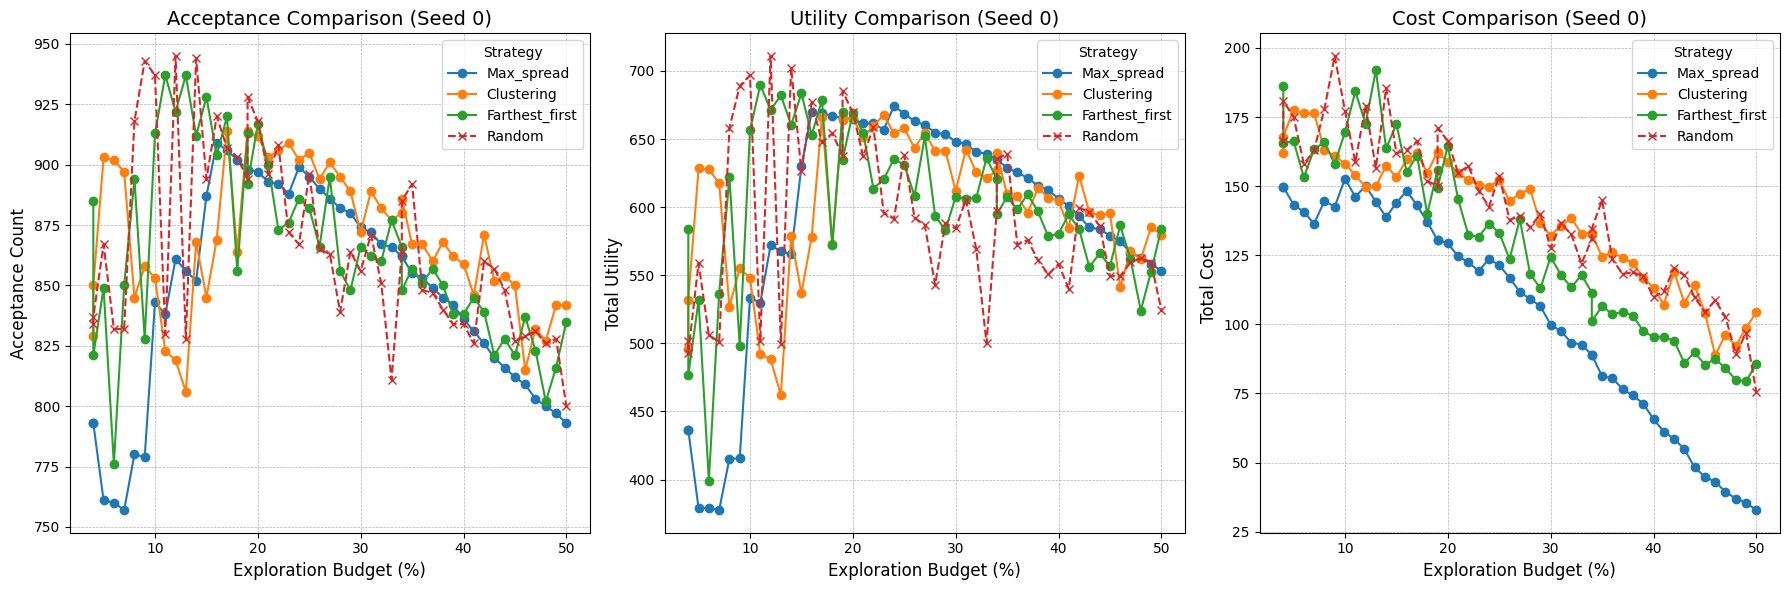

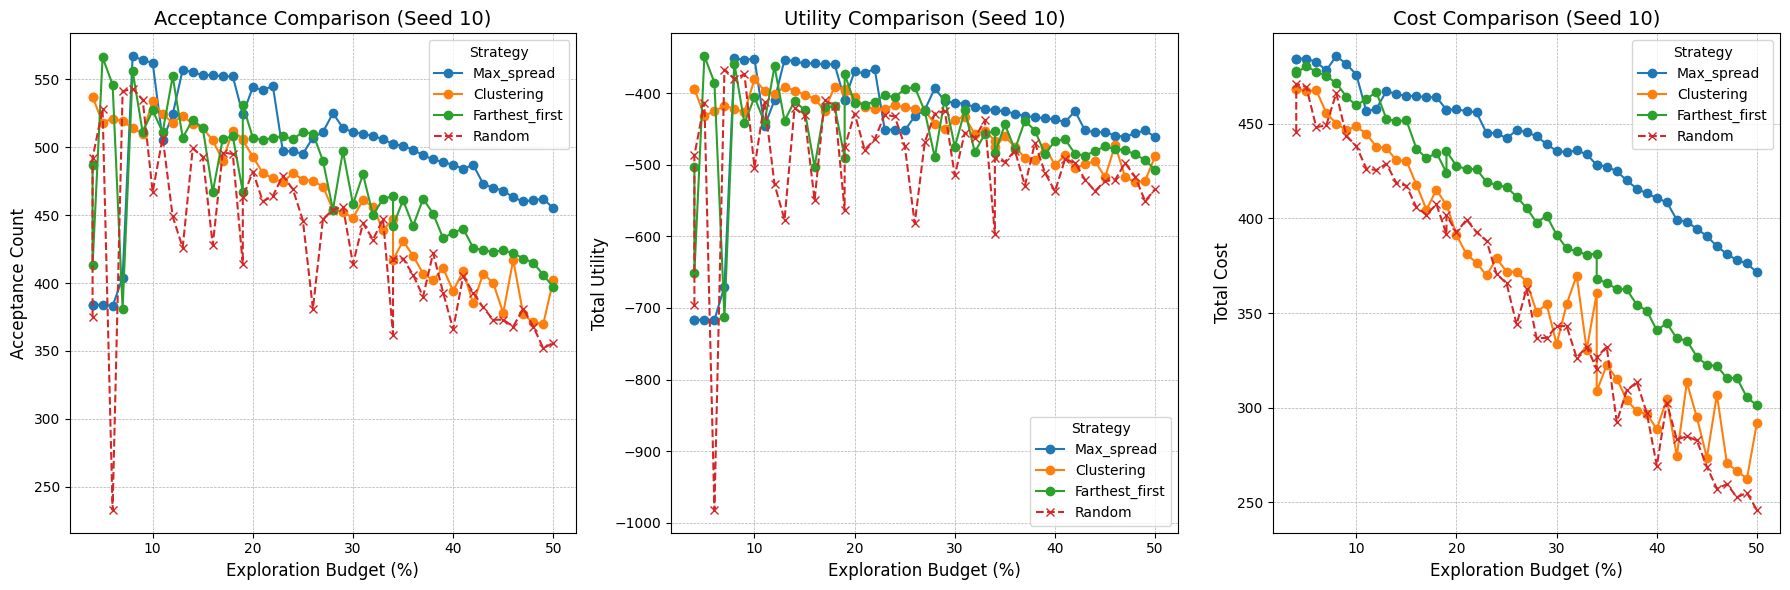

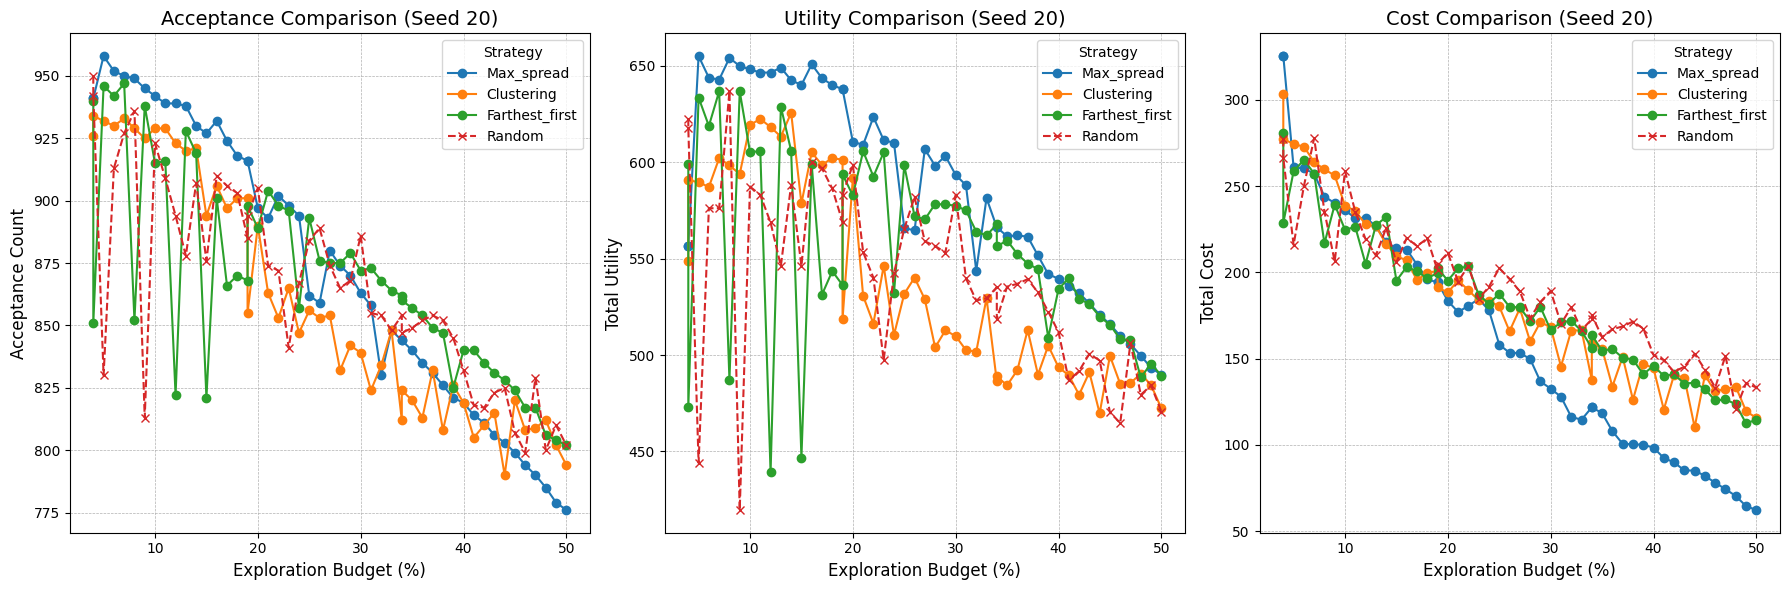

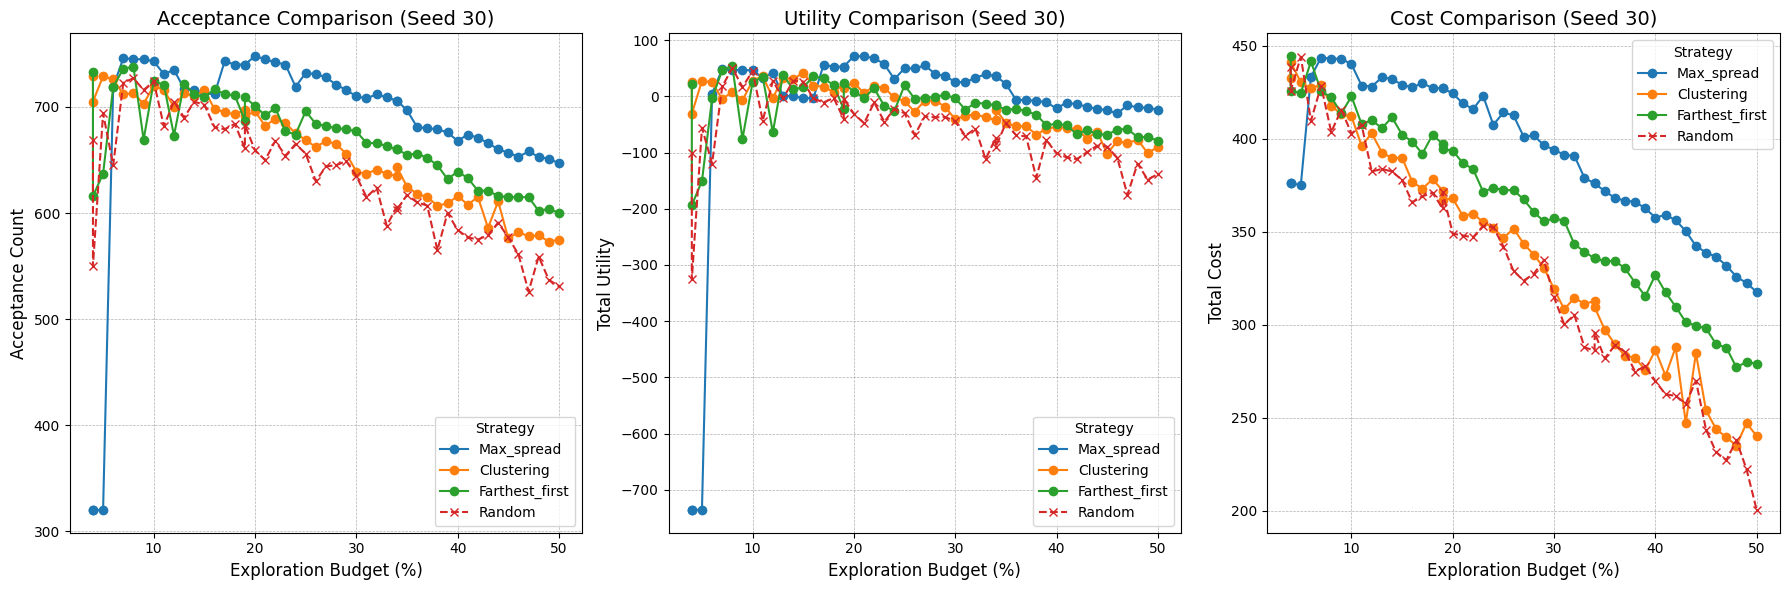

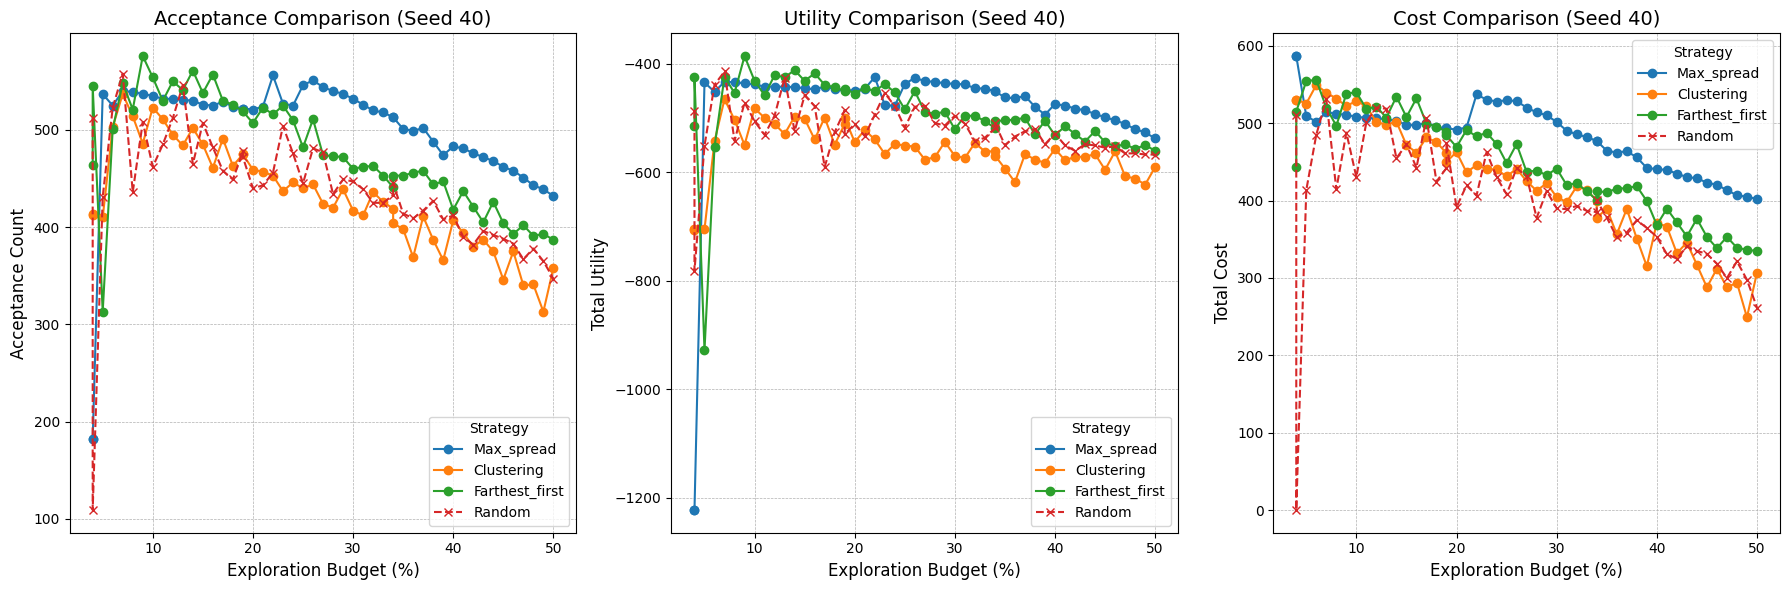

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# Seeds and parameter setup
seeds = [0, 10, 20, 30, 40]
exploration_percentages = np.linspace(4, 50, num=50, dtype=int)
strategies_to_compare = ['max_spread', 'clustering', 'farthest_first']

# For each seed, create a new environment only once
for seed in seeds:
    np.random.seed(seed)  # Controls random draws for this seed
    # Create a new environment for this seed (hidden classifier and initial agents are fixed here)
    env = SimulationEnv(hidden_dim=2, num_agents=1000, cost_function='l1')

    # Prepare arrays to store results for this seed
    random_results = {
        'acceptance': np.zeros(len(exploration_percentages)),
        'utility': np.zeros(len(exploration_percentages)),
        'cost': np.zeros(len(exploration_percentages))
    }
    strategy_results = {
        strategy: {
            'acceptance': np.zeros(len(exploration_percentages)),
            'utility': np.zeros(len(exploration_percentages)),
            'cost': np.zeros(len(exploration_percentages))
        } for strategy in strategies_to_compare
    }

    # Loop over exploration percentages
    for i, percentage in enumerate(exploration_percentages):
        # --- (A) Random Strategy ---
        env.reset_simulation()  # Reset agents to their original state
        env.run_exploration_phase(exploration_budget_percentage=percentage, strategy='random')
        env.run_exploitation_phase(safety_margin=1.2)
        _, _, our_acc = env.compute_acceptance_counts(gain_threshold=2)
        optimal_util, no_mod_util, our_util, optimal_cost, _, our_cost = env.compute_metrics(gain_threshold=2)
        random_results['acceptance'][i] = our_acc
        random_results['utility'][i] = our_util
        random_results['cost'][i] = (our_cost if our_cost is not None else 0)

        # --- (B) Alternative Strategies ---
        for strategy in strategies_to_compare:
            env.reset_simulation()  # Reset so that each strategy starts with the same hidden classifier and agents
            env.run_exploration_phase(exploration_budget_percentage=percentage, strategy=strategy)
            env.run_exploitation_phase(safety_margin=1.2)
            _, _, our_acc = env.compute_acceptance_counts(gain_threshold=2)
            optimal_util, no_mod_util, our_util, optimal_cost, _, our_cost = env.compute_metrics(gain_threshold=2)
            strategy_results[strategy]['acceptance'][i] = our_acc
            strategy_results[strategy]['utility'][i] = our_util
            strategy_results[strategy]['cost'][i] = (our_cost if our_cost is not None else 0)

    # ---------------------
    # Plotting results for the current seed
    # ---------------------
    plt.figure(figsize=(18, 6))

    # 1) Acceptance Comparison
    plt.subplot(1, 3, 1)
    for strategy in strategies_to_compare:
        plt.plot(exploration_percentages, strategy_results[strategy]['acceptance'],
                 label=strategy.capitalize(), marker='o', linestyle='-', markersize=6)
    plt.plot(exploration_percentages, random_results['acceptance'],
             label='Random', marker='x', linestyle='--', markersize=6)
    plt.xlabel("Exploration Budget (%)", fontsize=12)
    plt.ylabel("Acceptance Count", fontsize=12)
    plt.legend(title="Strategy", fontsize=10)
    plt.title(f"Acceptance Comparison (Seed {seed})", fontsize=14)
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)

    # 2) Utility Comparison
    plt.subplot(1, 3, 2)
    for strategy in strategies_to_compare:
        plt.plot(exploration_percentages, strategy_results[strategy]['utility'],
                 label=strategy.capitalize(), marker='o', linestyle='-', markersize=6)
    plt.plot(exploration_percentages, random_results['utility'],
             label='Random', marker='x', linestyle='--', markersize=6)
    plt.xlabel("Exploration Budget (%)", fontsize=12)
    plt.ylabel("Total Utility", fontsize=12)
    plt.legend(title="Strategy", fontsize=10)
    plt.title(f"Utility Comparison (Seed {seed})", fontsize=14)
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)

    # 3) Cost Comparison
    plt.subplot(1, 3, 3)
    for strategy in strategies_to_compare:
        plt.plot(exploration_percentages, strategy_results[strategy]['cost'],
                 label=strategy.capitalize(), marker='o', linestyle='-', markersize=6)
    plt.plot(exploration_percentages, random_results['cost'],
             label='Random', marker='x', linestyle='--', markersize=6)
    plt.xlabel("Exploration Budget (%)", fontsize=12)
    plt.ylabel("Total Cost", fontsize=12)
    plt.legend(title="Strategy", fontsize=10)
    plt.title(f"Cost Comparison (Seed {seed})", fontsize=14)
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)

    plt.tight_layout()
    plt.show()


# **Exploitation Strategy - safety margin optimization**


In this experiment, we focus on optimizing the **exploitation strategy** by tuning the safety margin parameter. We perform a grid search where we vary the exploration budget (ranging from 1% to 50% of the agents) and the safety margin (from 1.0 to 1.55 in steps of 0.05). For each combination, we run multiple trials (5 trials with 1000 agents each) using the "max_spread" strategy during exploration and then apply the exploitation phase with the specified safety margin. The total utility is computed for each trial, and an average utility is recorded for each pair of exploration budget and safety margin. We then identify the best combination that yields the highest average total utility. Finally, the results are visualized using a heatmap that plots average total utility against the varying safety margin and exploration budget. This experiment is designed to investigate how different safety margins affect the performance of the exploitation phase.







Best Average Total Utility: -92.65069487295027
Best Exploration Budget (%): 16
Best Safety Margin: 1.1500000000000001


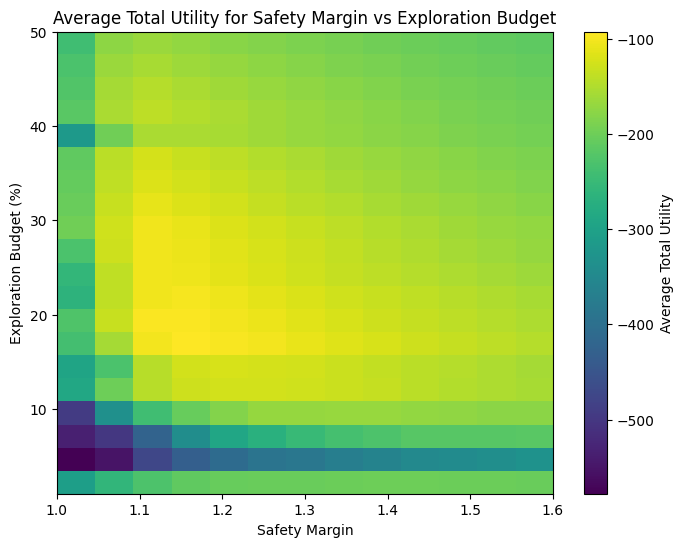

In [ ]:
# ----------------------------
# Experiment 3: Mini Experiment for Safety Margin Optimization
# ----------------------------
exploration_percentages = np.linspace(1, 50, num=20, dtype=int)
safety_margins = np.arange(1.0, 1.6, 0.05)
num_agents = 1000
num_trials = 5
avg_util_matrix = np.zeros((len(exploration_percentages), len(safety_margins)))
best_avg_util = -np.inf
best_budget = None
best_safety = None

for i, percentage in enumerate(exploration_percentages):
    for j, safety in enumerate(safety_margins):
        trial_utilities = []
        for trial in range(num_trials):
            np.random.seed(trial)
            env = SimulationEnv(hidden_dim=2, num_agents=num_agents, cost_function='l1')
            env.reset_simulation()
            env.run_exploration_phase(exploration_budget_percentage=percentage, strategy='max_spread')
            utilities = env.run_exploitation_phase(safety_margin=safety)
            total_util = np.sum(utilities)
            trial_utilities.append(total_util)
        avg_util = np.mean(trial_utilities)
        avg_util_matrix[i, j] = avg_util
        if avg_util > best_avg_util:
            best_avg_util = avg_util
            best_budget = percentage
            best_safety = safety

print("Best Average Total Utility:", best_avg_util)
print("Best Exploration Budget (%):", best_budget)
print("Best Safety Margin:", best_safety)

plt.figure(figsize=(8, 6))
extent = [safety_margins[0], safety_margins[-1], exploration_percentages[0], exploration_percentages[-1]]
plt.imshow(avg_util_matrix, aspect='auto', origin='lower', extent=extent)
plt.colorbar(label="Average Total Utility")
plt.xlabel("Safety Margin")
plt.ylabel("Exploration Budget (%)")
plt.title("Average Total Utility for Safety Margin vs Exploration Budget")
plt.show()

# Hypothesis 1: The Impact of Exploration Budget on Classifier Performance and Agent Acceptance

In this experiment, we systematically vary the **exploration budget**—the percentage of agents that query the hidden classifier—ranging from **5% to 100%**. We use a **max_spread** strategy to select agents during exploration, which aims to capture a diverse set of examples from the feature space. After collecting labels, we train an **SVM** (the “proposed classifier”) and run an **exploitation phase** where remaining agents can modify their features if the **L1** cost of crossing the decision boundary (scaled by a safety margin of **1.15**) is below a certain threshold. At each exploration budget level, we measure:
- **Classifier Understanding Accuracy:** How closely the SVM mimics the hidden classifier on random samples.
- **Acceptance Rate:** The fraction of agents ultimately accepted after exploitation.
- **Angle Metric:** The alignment between the hidden classifier’s weights and the SVM’s weights.
- **Utility and Cost:** How well agents do (reward minus modification cost) and how much cost is incurred overall.

The plots above reveal several trends. **Classifier understanding accuracy** (leftmost plot) generally increases with a higher exploration budget, as more data helps the SVM approximate the hidden boundary. **Acceptance rate** (second plot) peaks around moderate exploration budgets but declines at very high budgets, where additional exploration may yield diminishing returns relative to the cost. The **angle metric** (third plot) similarly improves, indicating better alignment between the SVM and the hidden classifier as more labeled data is gathered. In the bottom row, the **utility** plot shows how our approach (red line) compares against both no modification (gray) and the theoretical optimal scenario (blue). We see that moderate exploration budgets provide strong performance, whereas excessive exploration can reduce utility if the added data does not significantly improve classification. Finally, the **cost** plot (far right) illustrates that while our approach (purple line) does incur expenses for modifications, it remains below the optimal scenario’s cost (orange line) in many budget ranges. Together, these findings support the idea that **increasing exploration** can improve classifier performance and acceptance up to a point (around 20% explorers for commumity of 1000 agents), beyond which **diminishing returns** may lead to lower net benefits.

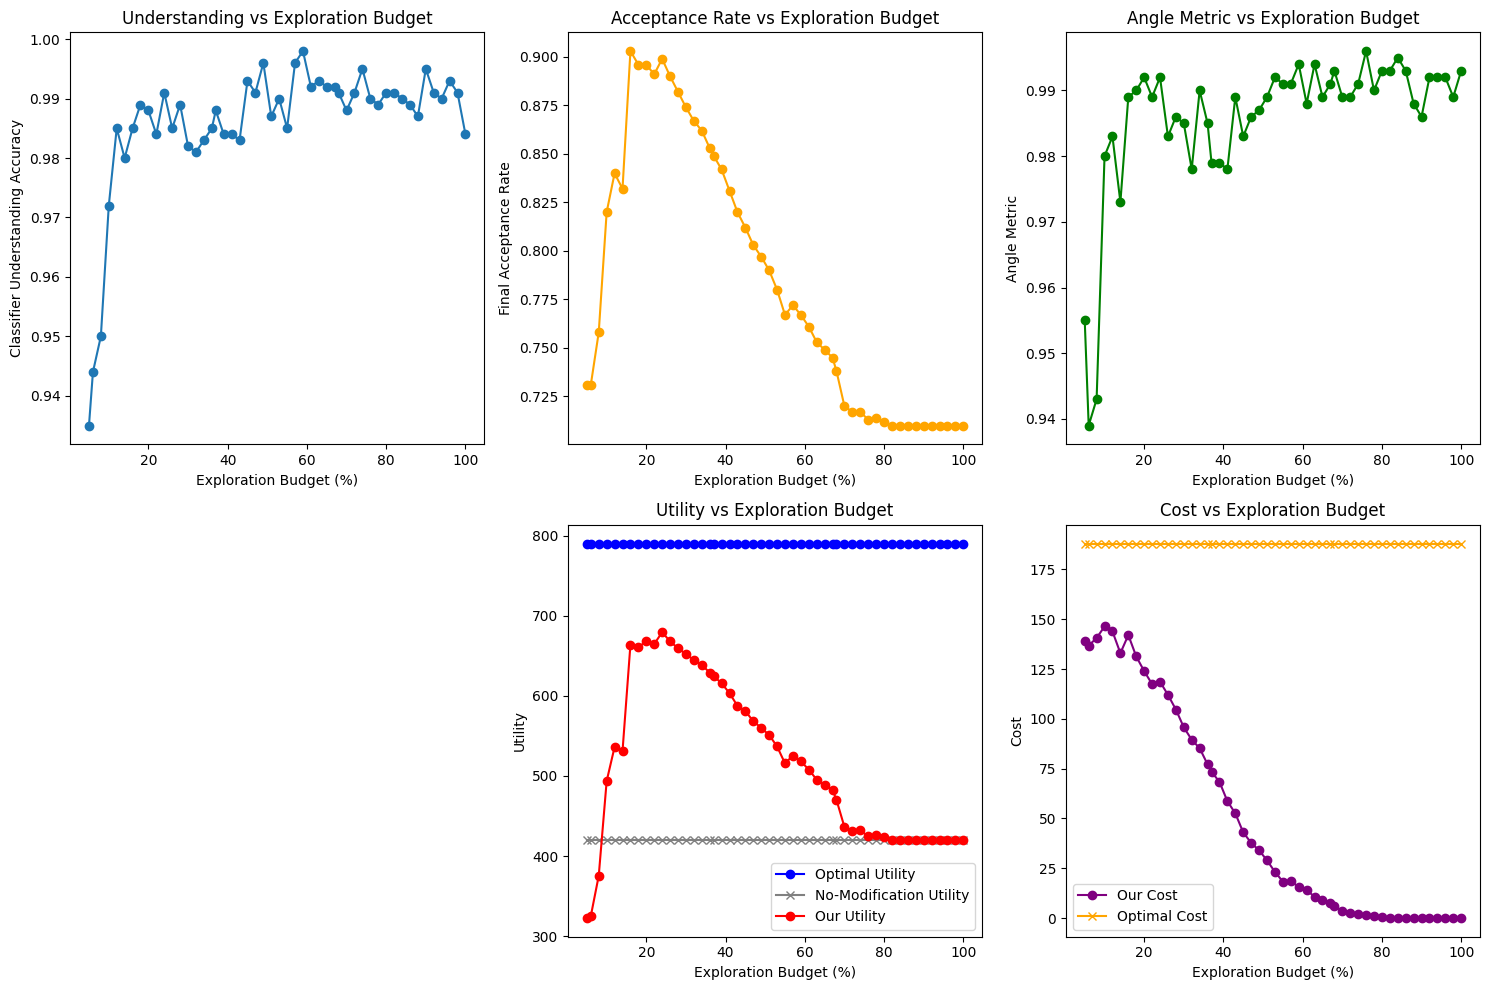

In [43]:
np.random.seed(0)
# ----------------------------
# Experiment 1: Impact of Exploration Budget (as Percentage) on Performance
# ----------------------------
# Use a larger environment with 1000 agents.
num_agents = 1000
env = SimulationEnv(hidden_dim=2, num_agents=num_agents, cost_function='l1')
# Define exploration percentages from 5% to 100%.
exploration_percentages = np.linspace(5, 100, num=50, dtype=int)
understanding_accuracies = []
acceptance_rates = []
angle_metrics = []
optimal_utilities = []
no_mod_utilities = []
our_utilities_list = []
optimal_costs = []
our_costs = []

for percentage in exploration_percentages:
    env.reset_simulation()
    # Use the max_spread strategy
    env.run_exploration_phase(exploration_budget_percentage=percentage, strategy='max_spread')
    understanding_accuracy = env.classifier_understanding_metric()
    env.run_exploitation_phase(safety_margin = 1.15)
    _, _, our_acc = env.compute_acceptance_counts(gain_threshold=2)
    acceptance_rate = our_acc / len(env.agents)
    # For angle metric, we re-use classifier understanding metric for demonstration.
    angle_metric = env.classifier_understanding_metric()
    optimal_util, no_mod_util, our_util, optimal_cost, _, our_cost = env.compute_metrics(gain_threshold=2)
    understanding_accuracies.append(understanding_accuracy)
    acceptance_rates.append(acceptance_rate)
    angle_metrics.append(angle_metric)
    optimal_utilities.append(optimal_util)
    no_mod_utilities.append(no_mod_util)
    our_utilities_list.append(our_util)
    optimal_costs.append(optimal_cost)
    our_costs.append(our_cost)

plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 1)
plt.plot(exploration_percentages, understanding_accuracies, marker='o')
plt.xlabel('Exploration Budget (%)')
plt.ylabel('Classifier Understanding Accuracy')
plt.title('Understanding vs Exploration Budget')
plt.subplot(2, 3, 2)
plt.plot(exploration_percentages, acceptance_rates, marker='o', color='orange')
plt.xlabel('Exploration Budget (%)')
plt.ylabel('Final Acceptance Rate')
plt.title('Acceptance Rate vs Exploration Budget')
plt.subplot(2, 3, 3)
plt.plot(exploration_percentages, angle_metrics, marker='o', color='green')
plt.xlabel('Exploration Budget (%)')
plt.ylabel('Angle Metric')
plt.title('Angle Metric vs Exploration Budget')
plt.subplot(2, 3, 5)
plt.plot(exploration_percentages, optimal_utilities, marker='o', color='blue', label='Optimal Utility')
plt.plot(exploration_percentages, no_mod_utilities, marker='x', color='grey', label='No-Modification Utility')
plt.plot(exploration_percentages, our_utilities_list, marker='o', color='red', label='Our Utility')
plt.xlabel('Exploration Budget (%)')
plt.ylabel('Utility')
plt.title('Utility vs Exploration Budget')
plt.legend()
plt.subplot(2, 3, 6)
plt.plot(exploration_percentages, our_costs, marker='o', color='purple', label='Our Cost')
plt.plot(exploration_percentages, optimal_costs, marker='x', color='orange', label='Optimal Cost')
plt.xlabel('Exploration Budget (%)')
plt.ylabel('Cost')
plt.title('Cost vs Exploration Budget')
plt.legend()
plt.tight_layout()
plt.show()


## Mini Experiment: Comparing Retraining Frequencies during Exploitation

In this mini experiment, we compare three conditions during the exploitation phase of our simulation:

1. **No Retraining:**  
   The SVM is not updated after the exploration phase. In this condition, the SVM remains fixed throughout exploitation.

2. **Retraining Every Step:**  
   The SVM is retrained after every single modification (i.e., after every agent’s exploitation step). This dynamic approach continuously updates the classifier with new information.

3. **Retraining Every 10 Steps:**  
   The SVM is retrained less frequently—after every 10 modifications. This aims to strike a balance between computational efficiency and the benefit of updating the classifier.

For all conditions, we use a community of **1000 agents** in a 2D feature space, with **20%** of the agents chosen as explorers via the **max_spread** strategy. A **safety margin** of **1.15** is applied during exploitation, and we use a **gain threshold** of **2** to determine if an agent should modify its features.

The experiment is run for multiple seeds (0, 10, 20, 30, and 40) to capture simulation variability. For each seed and each retraining condition, we compute:
- **Acceptance Counts:** The number of agents accepted under our approach.
- **Utility:** The overall benefit calculated as total reward minus modification cost.
- **Cost:** The total cost incurred during the exploitation phase.

In [27]:
import numpy as np

# Define seeds for experiments
seeds = [0, 10, 20, 30, 40]
NUM_AGENTS = 1000
EXPLORATION_PERCENTAGE = 20  # 20% of agents explore
SAFETY_MARGIN = 1.15
GAIN_THRESHOLD = 2  # Threshold for deciding to modify features

# For storing results for three conditions:
results_no_retrain = []
results_retrain_every = []
results_retrain_every_10 = []

for seed in seeds:
    # -------------------------------
    # Condition 1: No Retraining during Exploitation
    # -------------------------------
    np.random.seed(seed)
    env_no_retrain = SimulationEnv(hidden_dim=2, num_agents=NUM_AGENTS, cost_function='l1')
    env_no_retrain.reset_simulation()
    env_no_retrain.run_exploration_phase(exploration_budget_percentage=EXPLORATION_PERCENTAGE, strategy='max_spread')
    # Do not retrain during exploitation (retrain_every set to None)
    env_no_retrain.run_exploitation_phase(safety_margin=SAFETY_MARGIN, retrain_every=None)
    opt_acc, no_mod_acc, our_acc = env_no_retrain.compute_acceptance_counts(gain_threshold=GAIN_THRESHOLD)
    opt_util, no_mod_util, our_util, opt_cost, _, our_cost = env_no_retrain.compute_metrics(gain_threshold=GAIN_THRESHOLD)
    results_no_retrain.append({
        "seed": seed,
        "our_acc": our_acc,
        "our_util": our_util,
        "our_cost": our_cost
    })

    # -------------------------------
    # Condition 2: Retraining Every Step during Exploitation (retrain_every = 1)
    # -------------------------------
    np.random.seed(seed)
    env_retrain_every = SimulationEnv(hidden_dim=2, num_agents=NUM_AGENTS, cost_function='l1')
    env_retrain_every.reset_simulation()
    env_retrain_every.run_exploration_phase(exploration_budget_percentage=EXPLORATION_PERCENTAGE, strategy='max_spread')
    env_retrain_every.run_exploitation_phase(safety_margin=SAFETY_MARGIN, retrain_every=1)
    opt_acc, no_mod_acc, our_acc = env_retrain_every.compute_acceptance_counts(gain_threshold=GAIN_THRESHOLD)
    opt_util, no_mod_util, our_util, opt_cost, _, our_cost = env_retrain_every.compute_metrics(gain_threshold=GAIN_THRESHOLD)
    results_retrain_every.append({
        "seed": seed,
        "our_acc": our_acc,
        "our_util": our_util,
        "our_cost": our_cost
    })

    # -------------------------------
    # Condition 3: Retraining Every 10 Steps during Exploitation (retrain_every = 10)
    # -------------------------------
    np.random.seed(seed)
    env_retrain_every_10 = SimulationEnv(hidden_dim=2, num_agents=NUM_AGENTS, cost_function='l1')
    env_retrain_every_10.reset_simulation()
    env_retrain_every_10.run_exploration_phase(exploration_budget_percentage=EXPLORATION_PERCENTAGE, strategy='max_spread')
    env_retrain_every_10.run_exploitation_phase(safety_margin=SAFETY_MARGIN, retrain_every=10)
    opt_acc, no_mod_acc, our_acc = env_retrain_every_10.compute_acceptance_counts(gain_threshold=GAIN_THRESHOLD)
    opt_util, no_mod_util, our_util, opt_cost, _, our_cost = env_retrain_every_10.compute_metrics(gain_threshold=GAIN_THRESHOLD)
    results_retrain_every_10.append({
        "seed": seed,
        "our_acc": our_acc,
        "our_util": our_util,
        "our_cost": our_cost
    })

# Print the comparison results for each seed and condition
for i, seed in enumerate(seeds):
    print("Seed:", seed)
    print("  No Retraining: Our Approach Acceptance: {}/{} | Utility: {} | Cost: {:.2f}".format(
        results_no_retrain[i]["our_acc"], NUM_AGENTS, results_no_retrain[i]["our_util"], results_no_retrain[i]["our_cost"]))
    print("  Retraining Every Step: Our Approach Acceptance: {}/{} | Utility: {} | Cost: {:.2f}".format(
        results_retrain_every[i]["our_acc"], NUM_AGENTS, results_retrain_every[i]["our_util"], results_retrain_every[i]["our_cost"]))
    print("  Retraining Every 10 Steps: Our Approach Acceptance: {}/{} | Utility: {} | Cost: {:.2f}".format(
        results_retrain_every_10[i]["our_acc"], NUM_AGENTS, results_retrain_every_10[i]["our_util"], results_retrain_every_10[i]["our_cost"]))
    print("-" * 50)


Seed: 0
  No Retraining: Our Approach Acceptance: 896/1000 | Utility: 668.023704523553 | Cost: 123.98
  Retraining Every Step: Our Approach Acceptance: 866/1000 | Utility: 611.7697248765985 | Cost: 120.23
  Retraining Every 10 Steps: Our Approach Acceptance: 864/1000 | Utility: 608.3464938413416 | Cost: 119.65
--------------------------------------------------
Seed: 10
  No Retraining: Our Approach Acceptance: 549/1000 | Utility: -365.96448713629576 | Cost: 463.96
  Retraining Every Step: Our Approach Acceptance: 524/1000 | Utility: -424.7022262443397 | Cost: 472.70
  Retraining Every 10 Steps: Our Approach Acceptance: 525/1000 | Utility: -418.1445438717164 | Cost: 468.14
--------------------------------------------------
Seed: 20
  No Retraining: Our Approach Acceptance: 894/1000 | Utility: 612.1972117356609 | Cost: 175.80
  Retraining Every Step: Our Approach Acceptance: 834/1000 | Utility: 501.9353532982031 | Cost: 166.06
  Retraining Every 10 Steps: Our Approach Acceptance: 834/100

Across the five seeds, the "no retraining" condition generally produced higher acceptance rates and better overall utility compared to retraining every step or every 10 steps. For example, seeds 0 and 20 reached acceptance near 890 agents with utilities around 610–670, while seeds 10, 30, and 40—though showing negative utilities overall—still slightly favored no retraining. Additionally, the differences between retraining every step and every 10 steps were minimal, suggesting that dynamic updates offer little advantage over a fixed SVM after exploration.
